# Topic 3 -- Optimizing Your Learning Algorithm

Welcome back to the third topic of the Beginner AI Course! Now that we've come this far, together we have trained a handful of Linear and Logistic Regression algorithms. So far, machine learning seems quite plug-and-play. However, knowing how to put together a learning algorithm and train is only a **small part of ML**. A hugely important aspect of ML is **knowing how to optimize your learning algorithm**. In fact, this is what often separates amateur ML practitioners and advanced ML practitioners. This notebook covers bias and variance analysis, regularization, and lots more.

## Table of Contents

1. [Importing Modules](#mods)
    - [Feature Scaling](#scale)
    - [Standard Norm Implementation](#stdnorm)


2. [Bias and Variance](#bav)
    - [Loading our Dataset](#loading)
    - [Training Models with Different Degrees](#deg)
    - [Overfitting and Underfitting](#over)
    - [Observations](#obs1)
    
    
3. [Cross Validation](#crossval)
    - [Secondary Metric](#metric)
    - [Why do we even need Cross Validation?](#why)
    - [Summary](#summary)
    
    
4. [How to Deal with High Bias and High Variance](#deal)
     - [Fixing the problem of Underfitting](#under)
     - [Fixing the problem of Overfitting](#over)
     

5. [Regularization](#reg)
    - [L2 Regularization](#l2)
    - [L1 Regularization](#l1)
    - [L2 Regluarization in Action](#action)
    - [Observations](#obs2)
    
    
6. [The ML Process](#process)
    - [Iterate, Iterate, Iterate!](#iterate)
    - [Suggestions on Training Your ML Model](#suggestions)


## Importing Modules <a name="mods">

First things first, lets import our modules. Here is a brief description of the modules:
- **Numpy**: powerful linear algebra library
- **Pandas**: data organization and visualization 
- **SKLearn**: machine learning library with many data-science tools
- **Bokeh**, **SeaBorn**, and **MatPlotLib**: data plotting and visualization libraries
- **utils**: A custom module to display graphs

In [1]:
import numpy as np
import pandas as pd
import sklearn
from bokeh.plotting import figure, show, output_notebook
import matplotlib.pyplot as plt
from utils import *

# Makes sure that your notebook can display all columns of the dataframe
pd.set_option("display.max_columns", None)

## Feature Scaling <a name="scale">

Very often in machine learning, we find a dataset where the values seem to be on completely different **orders of magnitude**. For example, going back to the car mileage dataset, the **mileage** can range from 0 to 500,000 km, while the engine capacity ranges from 1.0 to 3.5. The massive difference in input space can cause some serious problems when trying to fit our models.

A solution to this problem is to **normalize** our data. This **scales** all the input values so that they are on a similar order of magnitude. Without getting into the mathematical details, here are some illustrations of cost functions of **non-normalized** and **normalized** inputs:

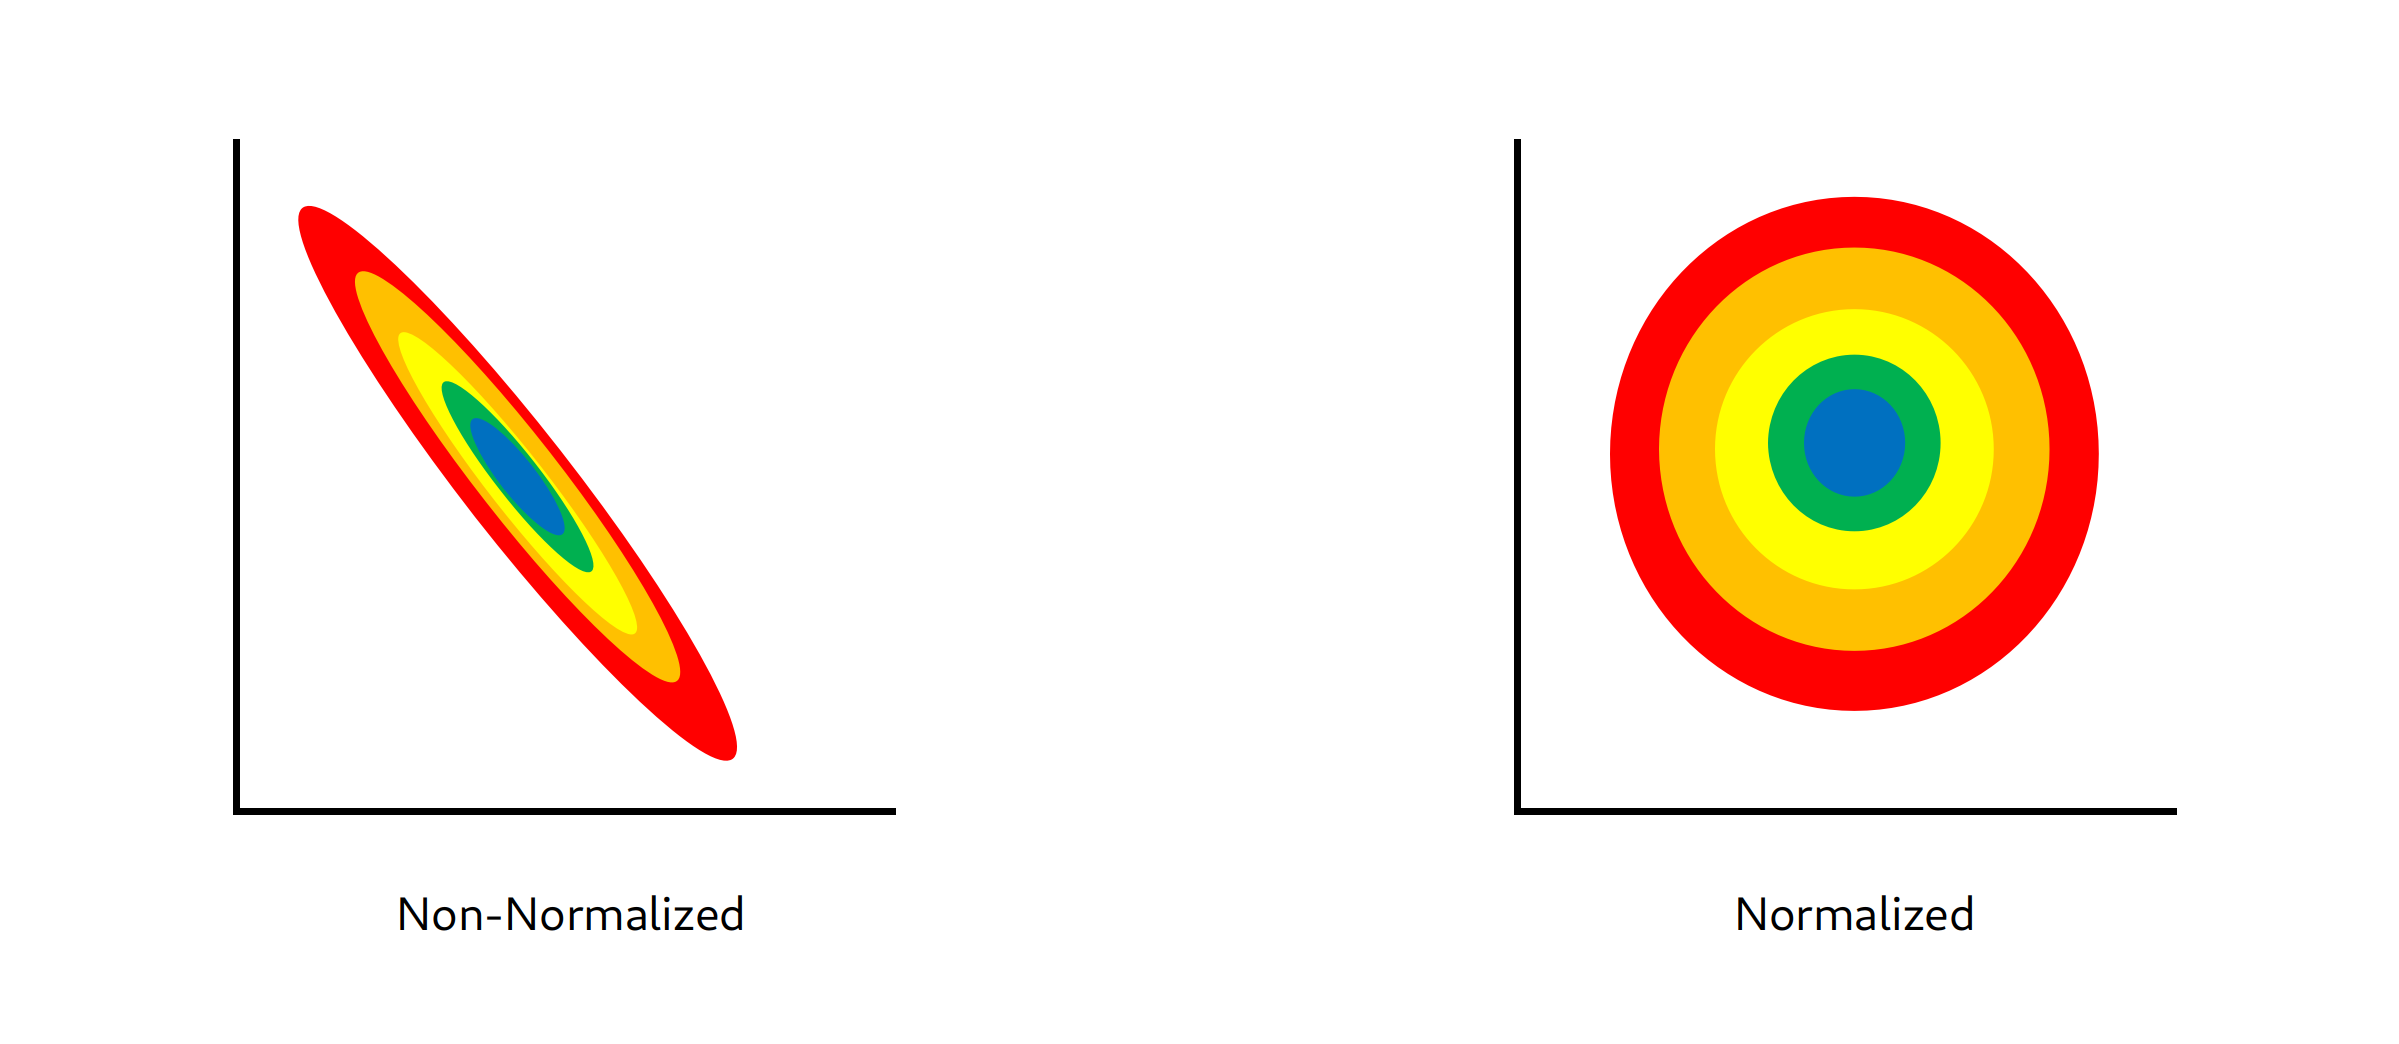
    
As you can see, **normalizing** the input data results in a **circular cost function** compared to the **elongated cost function** that comes from **non-normalized** data. This results in much faster gradient descent as well as greater stability.

### Standard Norm Implementation <a name="stdnorm"></a>

**Standard Normalization** is the most popular method of feature scaling used to make the cost function **easier to traverse**. While how it works is buried behind various math and statistics concepts we are not going to cover, standard norm can often make the difference between being able to train a learning algorithm and not being able to train it at all. In fact, the PyTorch `BatchNormalization` module was used for the purpose of standard normalization in previous programming projects, because without it, your models would have taken **hours** to train!
    
    
To implement standard norm in SKLearn, simply set the `normalize` parameter to True:
    
```python
model = LinearRegression(normalize=True) 
```

## Bias and Variance <a name="bav">

Previously, we have seen Linear Regression at work on the `cars.csv` dataset. We noted that extracting **polynomial features** from our dataset greatly increased the flexibility of our model, and thus led to a higher $R^2$ score than regular multi-variate linear regression. Does that mean *if we increase the degree of our polynomial, we will achieve higher correlation?*. Lets see for ourselves.

### Loading our Dataset <a name="loading">

This is the same dataset used in Topic 1. This dataset include the features, mileage, engine type, price, and many more about cars. We will start off by reading the `csv` file into a **Pandas DataFrame**.

In [2]:
dataset = pd.read_csv("datasets/cars.csv")
dataset.head(10)

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,price_usd,is_exchangeable,location_region,number_of_photos,up_counter,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,False,gasoline,2.5,universal,False,owned,all,10900.00,False,Минская обл.,9,13,False,True,True,True,False,True,False,True,True,True,16
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,False,gasoline,3.0,universal,False,owned,all,5000.00,True,Минская обл.,12,54,False,True,False,False,True,True,False,False,False,True,83
2,Subaru,Forester,automatic,red,402000,2001,gasoline,False,gasoline,2.5,suv,False,owned,all,2800.00,True,Минская обл.,4,72,False,True,False,False,False,False,False,False,True,True,151
3,Subaru,Impreza,mechanical,blue,10000,1999,gasoline,False,gasoline,3.0,sedan,False,owned,all,9999.00,True,Минская обл.,9,42,True,False,False,False,False,False,False,False,False,False,86
4,Subaru,Legacy,automatic,black,280000,2001,gasoline,False,gasoline,2.5,universal,False,owned,all,2134.11,True,Гомельская обл.,14,7,False,True,False,True,True,False,False,False,False,True,7
5,Subaru,Outback,automatic,silver,132449,2011,gasoline,False,gasoline,2.5,universal,False,owned,all,14700.00,True,Минская обл.,20,56,False,True,False,False,False,True,False,True,True,True,67
6,Subaru,Forester,automatic,black,318280,1998,gasoline,False,gasoline,2.5,universal,False,owned,all,3000.00,True,Минская обл.,8,147,False,True,False,False,True,True,False,False,True,True,307
7,Subaru,Legacy,automatic,silver,350000,2004,gasoline,False,gasoline,2.5,sedan,False,owned,all,4500.00,False,Брестская обл.,7,29,False,True,True,False,False,False,False,False,False,True,73
8,Subaru,Outback,automatic,grey,179000,2010,gasoline,False,gasoline,2.5,universal,False,owned,all,12900.00,False,Минская обл.,17,33,False,True,True,True,True,True,True,True,True,True,87
9,Subaru,Forester,automatic,silver,571317,1999,gasoline,False,gasoline,2.5,universal,False,owned,all,4200.00,True,Минская обл.,8,11,False,True,True,False,False,True,False,False,False,True,43


To start, we are going to use the exact same features as before, notably the `odometer_value`, `year_produced`, `engine_capacity`, `drivetrain`. Note that we have to convert `drivetrain` to categorical values. While we are at it, we can shuffle the data as well.

In [3]:
# Get dummy values for drive train
drivetrain = pd.get_dummies(dataset[['drivetrain']])
drivetrain # displays the dataframe in the notebook

# Converts categorical representation to a single number  (0, 1, 2)
dataset["drivetrain_num"] = np.argmax(drivetrain.to_numpy(), axis=1)
# Shuffles the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head(10)

# Features and Labels np.arrays
features = dataset[['odometer_value', 'year_produced', 'engine_capacity', 'drivetrain_num']].to_numpy()
labels = dataset['price_usd'].to_numpy()

# Gets rid of all NaN and replaces them with 0
features = np.nan_to_num(features, nan=0)

print(f"features shape: {features.shape}")
print(f"labels shape: {labels.shape}")

features shape: (38531, 4)
labels shape: (38531,)


### Training Models with Different Degrees <a name="deg">
 
Now that we have our **features** and **labels** defined, we can train our models! We are going to train three models with polynomial degrees of **1, 3,** and **10**. Keep in mind a polynomial of degree 1 is equivalent to regular multi-variate linear regression. Remember, our goal is to test **whether or not fitting higher degree polynomials would result in a better performing model**.

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Create polynomial features of degree 3 and 10
poly3 = PolynomialFeatures(degree=3)
poly10 = PolynomialFeatures(degree=10)

# Train test split
X_train_1, X_test_1, Y_train, Y_test = train_test_split(features, labels, test_size = 0.1)

# Transforming X_train and X_test
X_train_3 = poly3.fit_transform(X_train_1)
X_test_3 = poly3.fit_transform(X_test_1)
X_train_10 = poly10.fit_transform(X_train_1)
X_test_10 = poly10.fit_transform(X_test_1)


In [5]:
# Standard Normalization is enabled for all models
model1 = LinearRegression(normalize=True)
model3 = LinearRegression(normalize=True)
model10 = LinearRegression(normalize=True)

#Fitting the three models
model1.fit(X_train_1, Y_train)
model3.fit(X_train_3, Y_train)
model10.fit(X_train_10, Y_train)

print("R2 Score for Polynomial of degree 1: ", model1.score(X_test_1, Y_test))
print("R2 Score for Polynomial of degree 3: ", model3.score(X_test_3, Y_test))
print("R2 Score for Polynomial of degree 10: ", model10.score(X_test_10, Y_test))

R2 Score for Polynomial of degree 1:  0.613189502814855
R2 Score for Polynomial of degree 3:  0.820230461881531
R2 Score for Polynomial of degree 10:  -0.942888278926747


Yikes... It seems that our degree-10 polynomial regression performs the least consistent, many times with $R^2$ scores in the negatives. Now the question becomes, *Why does a high degree polynomial perform so poorly?*

### Overfitting and Underfitting <a name="over">

When dealing with large-scale machine learning projects, **very rarely** do we ever train the perfect model in the first try. Often times we run into fitting issues where our model is not fitting as well as we hope. Let's first remind ourselves about a few concepts we learned previously before we look at some visuals:

1. Gradient Descent will try to find the parameters that **minimize** the cost function. 
2. We use a **testing set** to evaluate our model, because these are data the model has never seen from training, and thus they cannot simply "memorize" the training set and apply on testing data. 

With that said, lets take a look at our first fitting problem:

In [6]:
disp_underfit()

Loading BokehJS ...

This model is said to have **"Underfit"** the data. This is because the the model is **too simple**, and is unable to fit the general trend of the data. When a model is underfitting, we say that the model has **High Bias**. Taking a look back at the three models we trained, `model1` underfits the data because for this specific problem of car prices, using a linear relation (polynomial degree of 1) simply isn't enough for the model to fit the data. With underfitting models, **training error is high and testing error is high**.

Lets take a look at our next example of poor fitting:

In [7]:
disp_overfit()

Loading BokehJS ...

This model is said to have **"Overfit"** the data. The model is **far too complex**, (In this case it is a degree 10 polynomial), and fits the training set way too well. When the model trains, gradient descent **minimizes** the cost function. Here, the hypothesis function seems to **pass through every single point**, so the cost is **virtually zero**. However, when we expose our model to testing data, it will **fit the testing data very poorly**. Overfitting models are said to have **High Variance**. With overfitting models, **training error is low but testing error is high**

Finally, let's see a properly-fit model:

In [8]:
disp_good_fit()

Loading BokehJS ...

Notice that with a properly-fit model, there may still be a bit of errors with the training set and the hypothesis function, but that is okay, as this is still the model that **generalizes** the best onto the test set. In this example, we used a degree 3 polynomial. When a model is properly fit, **both training error and testing error are low**

### Observations <a name="obs1">
    
Before we forget, it's important to document our findings. We noted that `model1` was too simple and underfit our training data, `model3` had the best fit out of all the models, and `model10` severely overfit our data. Let's write this down.
    
| Model | Observations | R2 |
|:--- | :--- | :--- |
| model1 | Mediocre fit on our testing set | 60% |
| model3 | Good fit of our testing set | 80% |
| model10 | Inconsistant fit to our testing set, most likely due to overfitting | NA |
    
---

## Cross Validation <a name="crossval">
    
We've seen how **high variance** (overfitting) and **high bias** (underfitting) looks like in terms of how the hypothesis function looks like when fitted to the data, however in most Machine Learning problems, we simply **cannot visualize the hypothesis function**. However, when training, the **cost function** can give us a clue to how our model is fitting.
    
Recall that we just talked about the differences in training error and testing error between high variance, high bias, and correctly fit models. The goal is to visualize the **trends** in training and testing error over the **many iterations** we train our model. For this, **we will create a new split in our data**. Up until now, we split our dataset into training sets and testing sets. Now, we will create a new split called **cross validation**. This set is very similar to the testing set, as the **model will not be learning from the cross validation set**.
    
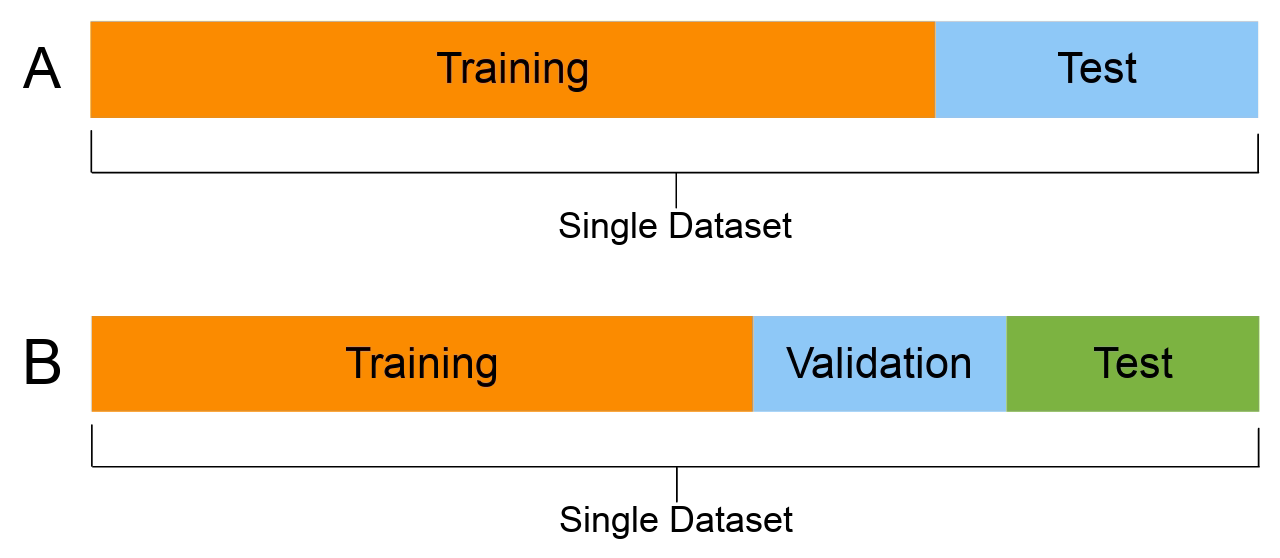
    
    
Now, after every training iteration of our model, we will record the **training error** as well as the **cross validation** error. These error plots can give us clues on whether our model is overfitting, underfitting, or correctly fitting.

In [9]:
disp_cost_plots()

Loading BokehJS ...

**High Bias**: 
- High training costs, suggesting that your model cannot even fit the training set, let alone the cross validation and test sets.
- Even higher cross validation cost

**High Variance**:
- Low training costs sugessting a very good fit to the training set
- High cross validation costs sugesting a very poor fit to the cross validation set

**Proper fit**:
- Low training costs sugesting a very good fit to the training set
- Low cross validation costs sugesting a good fit to the cross validation set.


### Secondary Metric <a name="metric"></a>
    
Our primary metric has been our losses, both for **training** and **cross validation**. While this gives us a good way of determining whether our model is overfitting or underfitting, sometimes its good to also carry a **secondary metric** for further validation. 
    
Recall our **GPU Performance Predictor**: We trained a polynomial regression model that had **massive training losses**. We might conclude that the model was underfitting, however we saw that the $R^2$ score was around 0.95, which shows that our model is actually fitting very nicely. Thus, whether it is linear regression or logistic regression, it's good to include **$R^2$ scores** or **Accuracy and F1** alongside the loss.

### Why do we even need Cross Validation <a name="why"></a>

So far we've looked at how cross validation could be used to monitor the model's **costs every iteration** on data it's never seen before. That begs the question: *Is the cross validation set even necessary? Why can't we use the test set as the cross validation set? Also, why can't we use the cross validation set as the test set?* 

In machine learning, often times your model requires so much data that you have to collect data from multiple **sources**. Say you are creating a **cat-classifier**. You decided to collect **labeled training data** from online, and for the testing set, you took pictures of cats with your phone. Notice that this scenario is **quite common**, where you have a **labeled dataset you use for training**, and the **test set contains no labels**. This is because labelling data is very **time consuming**, so people often skip labelling the test set.

So far here's the run-down: You have a labeled training set obtained from online, and an un-labeled test set obtained from your phone camera. Unfortunately, you cannot use the test set to moniter the per-iteration loss, because there is **no label to compute the loss!**

You want to compute the loss per iteration so you can tune your model, so you split off some examples from your labeled training set and use it for **cross-validation**. By using your newly-formed cross validation set, you were able to create **cost graphs** and prevent your model from overfitting. 

#### Question for students:
Now your model no longer overfits to the training set, and generalizes to the cross validation set. Is this enough?

> #### Anser:
> **No!** While your model performs **very well on the cross validation set**, it **might not perform that well on the test set!** This is because your test set comes from your **phone**, whereas when you tuned the model to work well on the cross validation set, you are tuning your model to work well on photos **from the internet**. These are two **different** sources, therefore it is necessary to **check with your test set** to determine whether or not it also generalizes here.



### Summary <a name="summary">
    
Creating a cross validation split of your data allows you to **track** the **costs** and a **secondary metric** of your learning algorithm **on a set of data it has never seen before**, thus allowing you to catagorize your algorithm as **underfitting, overfitting,** or **fitting just right**. While the cross validation set behaves similarly to the test set, it should not replace the test set.
    
---

## How to Deal with High Bias and High Variance <a name="deal">
    
Now that we've demonstrated how to **diagnose** whether your model was overfitting or underfitting, now we need to talk about how to **solve** overfitting and underfitting problems. 
    
### Fixing the problem of Underfitting <a name="under">
    
Luckily, underfitting is one of the **easiest** problems to solve. Just get a bigger model! That can be done by obtaining more features to train on (**Hint: One way to do that is to create polynomial features, which we have been doing for the past little bit.**)
    
### Fixing the problem of Overfitting <a name="over">
    
Overfitting can be **much harder** to fix. It happens when your model is **too complicated**, and is able to fit the training data in ways that are undesireable. This is why in supervised learning, there are many methods of preventing overfitting, including **Dropout**, **Batch Norm**, etc. In this chapter we are going to talk about **Regularization**.
  
---

## Regularization <a name="reg">

Regularization is a powerful method of **reducing the complexity** of a learning algorithm. This is very helpful in preventing your model from **overfitting**. Today, we are going to talk about **two** of the most popular regularization methods.

### L2 Regularization <a name="l2">
    
L2 Regularization, also known as **Ridge** regularization, is by far the most popular method of regularization, therefore we will use this throughout this course. L2 works by **preventing** the weights and bias from getting **too large**, therefore keeping the model from becoming too complex. Let's take a look at what happens when we apply regularization to our degree 10 Polynomial. For this example, we found that a regularization parameter of 3.36 works the best.

In [10]:
disp_reg(3.36)

Loading BokehJS ...

### L1 Regularization <a name="l1">
    
L1 Regularization, also known as **Lasso** regularization, is not as popular as L2, but achieves the same goal of keeping weights and bias from getting too large. We won't get into the details of L1 regularization in this course.
    
    
### L2 Regularization in Action <a name="action">
    
Previously, we've trained three polynomial regression models with degrees of **1, 3,** and **10**. We noticed that `model1` underfits the data, therefore there is not much regularization would do to fix the problem. However, `model10` overfits the data, therefore lets see if Ridge regularization could **simplify** the model so that it fits better.
    
Here, we will use the `Ridge()` class to train our new regularized model. The `Ridge` class takes in a parameter `alpha` that represents the 'regularization strength' -- 0 means no regularization, and higher values will have stronger regularizations. Try `alpha = 1e-8`.

In [11]:
from sklearn.linear_model import Ridge

# Ridge regression uses L2 (Ridge) regularization
model = LinearRegression(normalize=True)
model_ridge = Ridge(alpha=1e-8, normalize=True)

model.fit(X_train_10, Y_train)
model_ridge.fit(X_train_10, Y_train)

print(model.score(X_test_10, Y_test))
print(model_ridge.score(X_test_10, Y_test))

-0.942888278926747
0.8354975381496169


#### Challenge

> Try using different values of `alpha`, see if you can improve the $R^2$ score.

### Observations <a name="obs2">

The difference regularization makes is tremendous. The model went from an overfitting mess into one that performs either **on par or better than our best performing model which fits a degree 3 polynomial**. Let's record our findings down below.
    
| Model | Observations | R2 |
|:--- | :--- | :--- |
| model1 | Mediocre fit on our testing set | 60% |
| model3 | Good fit of our testing set | 80% |
| model10 | Inconsistant fit to our testing set, most likely due to overfitting | NA |
| model_ridge | Much better fit to our testing set, despite using a degree 10 polynomial | 81% |
    
    
---

## The ML Process <a name="process">
    
Congrats on making it this far! In the previous topics, we've built and played around with Linear Regression and Logistic Regression models. As far as the programming projects go, we gave you the ideal **learning rates** and **epochs**, as well as set up some other parameters so that our model would perform well. However, Machine Learning in truth is quite different, as you'll need to experiment to find the perfect **hyperparameters** for training and evaluating. 
    
    
### Iterate, Iterate, Iterate! <a name="iterate">
    
Machine Learning is a highly **iterative** process. Sometimes training a model can take **weeks, months,** or even **years** to do. It is **completely normal** to train a learning algorithm and not get it right the first time. Here is a graphic created by **Dr. Andrew Ng** of Stanford University, one of the leading researchers of deep learning.
    
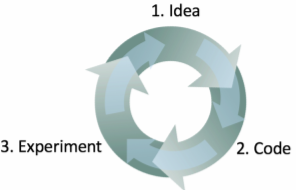
    
1. **Idea**: Start off with an idea of what you want to do, whether it is create a new ML algorithm or tune your existing algorithm
    
2. **Code**: Carry out your idea in code
    
3. **Experiment**: Test your code to see if your idea worked or not. Often times the results of experimentation will bring up new ideas for you to implement.
    
    
#### Hot Take:
The faster you can iterate, the sooner you can deploy your machine learning model. **HOWEVER**: fast iteration does not equal rushed iteration.
    
    
    
### Suggestions on Training Your ML Model <a name="suggestions">
    
1. **Make sure your error is going down**: If your loss ever becomes `NaN` or gets bigger, that means your learning rate is too high.
    
    
2. If you think your model is **underfitting**, go for a bigger model (get more features, use polynomial features)
    
    
3. **Make sure your model fits the training set well enough first**: During development, the first few trials should overfit. **If it can't even fit the training set, it cannot fit the cross validation and testing sets!**
    
    
4. **AFTER** you determined that your model can fit the training set (overfitting), **THEN** apply regularization to make it generalize to the cross validation set
    
    
5. **Keep Iterating** until you are satisfied with the cross validation loss as well as the cross validation accuracy or $R^2$. On every iteration, **tune** your hyperparameters such as **learning rate** and **regularization**, and compare with the previous iteration to see if your model is improving
    

## $\mathcal{Fin}$ <a name="fin">
    
Congrats on making it to the end of this notebook! Next up, we will explore the power of regularization in a made-up storyline titled **"Cat-astrophe"**.
    
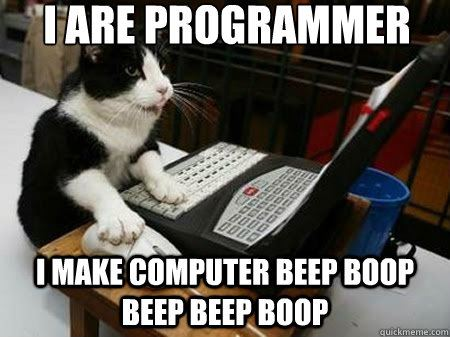